In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
import numpy as np 

from gptchem.data import get_polymer_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

from gptchem.plotsettings import *

import matplotx

%matplotlib inline

In [3]:
all_res = glob("out/**/*.pkl")

In [4]:
res = load_pickle(all_res[0])

In [9]:
temperatures = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [17]:
res

{'composition_mismatches':        distances  min  max  mean  expected_len  found_len
 0   [0, 0, 0, 0]    0    0   0.0             0          0
 1   [0, 0, 0, 0]    0    0   0.0             0          0
 2   [0, 0, 0, 0]    0    0   0.0             0          0
 3   [0, 0, 0, 0]    0    0   0.0             0          0
 4   [0, 0, 0, 0]    0    0   0.0             0          0
 ..           ...  ...  ...   ...           ...        ...
 84  [0, 0, 0, 0]    0    0   0.0             0          0
 85  [0, 0, 0, 0]    0    0   0.0             0          0
 86  [0, 0, 0, 0]    0    0   0.0             0          0
 87  [0, 0, 0, 0]    0    0   0.0             0          0
 88  [0, 0, 0, 0]    0    0   0.0             0          0
 
 [89 rows x 6 columns],
 'summary_composition_mismatches': {'min': 0.0,
  'max': 0.0,
  'mean': 0.0,
  'expected_len': 0.0,
  'found_len': 0.0},
 'losses': [1.1750889636501762,
  0.4644589765197793,
  0.34433516350504867,
  7.452705921164279,
  2.685653506374111,


In [10]:
compiled_res = []

for filename in all_res: 
    loaded = load_pickle(filename)
    try:
        for i, res in enumerate(loaded['res']):
            result = {
                'num_train_points': loaded['num_train_points'],
                'noise_level': loaded['noise_level'],
                'valid_fraction': res['valid_smiles_fraction'],
                'unique_fraction': res['unique_smiles_fraction'],
                'temp': temperatures[i],
                'kldiv_score': res['kldiv_score'],
                'mae': np.mean(res['losses']),
                **res['string_distances_collection_summary']
            }
            for k,v in res['summary_composition_mismatches'].items():
                result[f'comp_mismatch_{k}'] = v
        
            compiled_res.append(result)
    except Exception as e :
        print(e)
        pass
        

In [11]:
df = pd.DataFrame(compiled_res)

In [12]:
grouped = df.groupby(['num_train_points', 'temp']).agg(['mean', 'std'])

In [13]:
grouped['LongestCommonSubsequence_mean']

mean         std
num_train_points temp                        
100              0.00  472.982771  190.211485
                 0.10  406.448629  167.096639
                 0.20  201.063199  140.980858
                 0.50   52.683467   10.626993
                 0.75   44.644120    2.931887
                 1.00   41.896320    0.746767
                 1.25   41.559750    0.394324
                 1.50   45.213483         NaN
300              0.00  255.985133   58.877713
                 0.10   96.765867   33.807809
                 0.20   56.500267    6.891523
                 0.50   44.809667    1.022394
                 0.75   43.401600    0.991015
                 1.00   41.603704    0.305192
                 1.25   41.642948    0.876756
                 1.50   42.077956    0.110554
1000             0.00   56.107800    4.322685
                 0.10   52.325900    0.368685
                 0.20   49.323300    1.252286
                 0.50   44.513200    0.902551
                 0.75   43.827000    0.064205
                 1.00   42.422500    0.124592
                 1.25   42.189016    1.026413
                 1.50   44.092128    1.142805

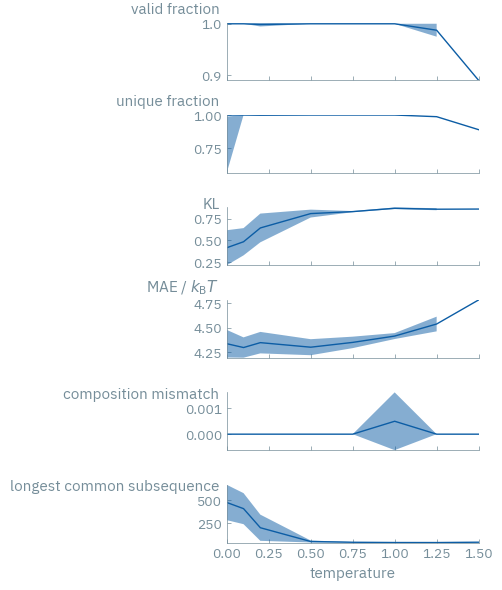

In [16]:
fig, ax = plt.subplots(6,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))

ax[0].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[0].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['valid_fraction']['mean'] -  grouped.loc[100, :]['valid_fraction']['std'], 
    grouped.loc[100, :]['valid_fraction']['mean'] +  grouped.loc[100, :]['valid_fraction']['std'], alpha=.5 )
ylabel_top('valid fraction', ax=ax[0])


ax[1].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[1].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['unique_fraction']['mean'] -  grouped.loc[100, :]['unique_fraction']['std'], 
    grouped.loc[100, :]['unique_fraction']['mean'] +  grouped.loc[100, :]['unique_fraction']['std'], alpha=.5 )
ylabel_top('unique fraction', ax=ax[1])

ax[2].plot(grouped.loc[100, :].index, grouped.loc[100, :]['kldiv_score']['mean'])
ax[2].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['kldiv_score']['mean'] -  grouped.loc[100, :]['kldiv_score']['std'], 
    grouped.loc[100, :]['kldiv_score']['mean'] +  grouped.loc[100, :]['kldiv_score']['std'], alpha=.5 )
ylabel_top('KL', ax=ax[2])

ax[3].plot(grouped.loc[100, :].index, grouped.loc[100, :]['mae']['mean'])
ax[3].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['mae']['mean'] -  grouped.loc[100, :]['mae']['std'], 
    grouped.loc[100, :]['mae']['mean'] +  grouped.loc[100, :]['mae']['std'], alpha=.5 )
ylabel_top('MAE / $k_\mathrm{B}T$', ax=ax[3])

ax[4].plot(grouped.loc[100, :].index, grouped.loc[100, :]['comp_mismatch_mean']['mean'])
ax[4].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['comp_mismatch_mean']['mean'] -  grouped.loc[100, :]['comp_mismatch_mean']['std'], 
    grouped.loc[100, :]['comp_mismatch_mean']['mean'] +  grouped.loc[100, :]['comp_mismatch_mean']['std'], alpha=.5 )
ylabel_top('composition mismatch', ax=ax[4])


ax[5].plot(grouped.loc[100, :].index, grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'])
ax[5].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] -  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], 
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] +  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], alpha=.5 )
ylabel_top('longest common subsequence', ax=ax[5])

ax[-1].set_xlabel('temperature', labelpad=4)
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)
fig.savefig('random_comp_polymer_inverse.pdf', bbox_inches='tight')

In [ ]:
np.abs(get_polymer_data()['deltaGmin'].mean() - get_polymer_data()['deltaGmin']).mean()

2.7135963497608304